In [ ]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
audio_path = "/content/colorofsky.wav"
waveform, sample_rate = torchaudio.load(audio_path)

print(waveform)
print(sample_rate)
print(waveform.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0090, -0.0098, -0.0111],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0032, -0.0009,  0.0003]])
48000
torch.Size([2, 148608])


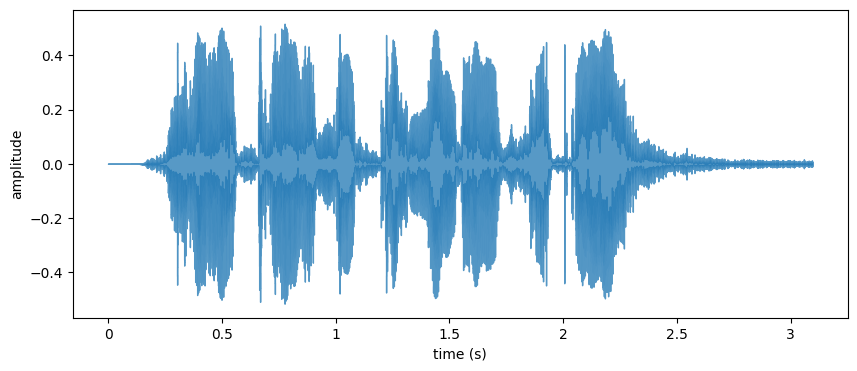

In [ ]:
y, sr = librosa.load(audio_path, sr = None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.75)
plt.xlabel("time (s)")
plt.ylabel("amplitude")

plt.show()

In [ ]:
if sample_rate != 16000:
  resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
  waveform = resample(waveform)

if waveform.shape[0] > 1:
  waveform = waveform.mean(dim=0, keepdim=True)

In [ ]:
# whsiper encoder converts raw waveform into mel_spectogram and then gives it to the CNN layers but wav2vec2 encoder directly gives raw waveform to teh CNN layers

conv1 = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=10, stride=5, padding=5)

conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)

conv3 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)

conv4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)

conv5 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)

conv6 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0)

conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0)

relu = nn.ReLU()

In [ ]:
waveform = conv1(waveform)
waveform = relu(waveform)

waveform = conv2(waveform)
waveform = relu(waveform)

waveform = conv3(waveform)
waveform = relu(waveform)

waveform = conv4(waveform)
waveform = relu(waveform)

waveform = conv5(waveform)
waveform = relu(waveform)

waveform = conv6(waveform)
waveform = relu(waveform)

waveform = conv7(waveform)
waveform = relu(waveform)

In [ ]:
waveform.shape

torch.Size([512, 51])

In [ ]:
waveform

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0210, 0.0216, 0.0216,  ..., 0.0216, 0.0216, 0.0216],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0442, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435]],
       grad_fn=<ReluBackward0>)

In [ ]:
# major difference between whisper encoder and wav2vec2 encoder is the input dimension for transformer encoder layers in whisper is 512 and in wav2vec is 768
# input dimension projector before giving it to the transformer layers
# batch_normalization is remaining before we put it into tarining loop

waveform = waveform.permute(1, 0)
projection = nn.Linear(512, 768) # linear transformation
projected_output = projection(waveform)

In [ ]:
projected_output

tensor([[-0.0312, -0.0009,  0.0123,  ...,  0.0306,  0.0339,  0.0250],
        [-0.0314, -0.0009,  0.0123,  ...,  0.0308,  0.0340,  0.0250],
        [-0.0314, -0.0009,  0.0123,  ...,  0.0308,  0.0340,  0.0250],
        ...,
        [-0.0314, -0.0009,  0.0123,  ...,  0.0308,  0.0340,  0.0250],
        [-0.0314, -0.0009,  0.0123,  ...,  0.0308,  0.0340,  0.0250],
        [-0.0314, -0.0009,  0.0123,  ...,  0.0308,  0.0340,  0.0250]],
       grad_fn=<AddmmBackward0>)

In [ ]:
# Transformer layers
# Another differrence: whisper uses SiLU activation function for transformer layer and wav2vec2 uses gelu activation function

encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, activation="gelu", batch_first=True)

In [ ]:
print(encoder_layer)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


In [ ]:
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=12)

In [ ]:
speech_embeddings = transformer_encoder(projected_output)

# the speech embeddings produced by wav2vec2 encoders are flexible and can be integrated into many endtoend architectures whereas the latent representations of whisper encodings are mainly for its own decoder and is not that flexible.

In [ ]:
print(speech_embeddings)
print(speech_embeddings.shape)

tensor([[ 0.6025,  0.4629, -0.4900,  ...,  0.7190, -2.2026, -1.3299],
        [ 0.8611,  0.1726, -0.3417,  ...,  0.9001, -2.2658, -1.1884],
        [ 0.7921,  0.0722, -0.3946,  ...,  0.6217, -2.6996, -1.1774],
        ...,
        [ 0.9512,  0.3228, -0.4453,  ...,  0.9563, -2.1974, -1.1646],
        [ 0.8278,  0.2700, -0.2943,  ...,  1.0898, -2.3052, -1.1473],
        [ 0.8831,  0.4053, -0.2922,  ...,  0.9330, -1.7860, -1.2441]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([51, 768])
